In [1]:
import pandas as pd
import pickle
import os 
pd.options.mode.chained_assignment = None
import datetime
import numpy as np
import os
import zipfile
import modules.ml_pipeline.readdata as mlpp
import sys

# Read and manipulate the dataset

In [2]:
# unzip the zip dataset
with zipfile.ZipFile('data/converted_full.zip', 'r') as zip_ref:
    zip_ref.extractall('data')

# Load the raw data to disk
input_path = "data/converted.csv"
df = pd.read_csv(input_path)

# Convert all column names to lower case and display the dataframe 
df = df.rename(str.lower, axis='columns')

In [3]:
# Do some manipulations on the data and clean it (remove rows of all NaNs, remove duplicates, etc.)

# Remove any rows that have buoy velocity/mag =0 
df = df[df["buoy_vel_mag"] != 0]

# Remove any rows that have very low ice_thickness  
"""
sea ice concentration of 0.5 means that the surroundings of the buoy is 50% sea ice and 50% open water. So ice concentration of 
1 is full ice cover, while a concentration of 0.1 means there’S barely any ice left at that location!
"""
df = df[df["sic_cdr"] > 0.1]

# Print the dataframe dimensions
print("Dataframe final shape: ", df.shape)
display(df)

Dataframe final shape:  (329279, 21)


,index,year,month,day,doy,x_ease,y_ease,u_buoy,v_buoy,id_buoy,...,v_era5,sic_cdr,d2c,ice_thickness,buoy_lat,buoy_lon,buoy_vel_mag,buoy_vel_dir,wind_vel_mag,wind_vel_dir
0,0,1979,2,18,49,147.506958,138.582672,-0.797554,1.114740,1906,...,-0.321260,0.990195,522.523298,3.189743,78.007070,-128.549129,1.370671,2.191824,6.711849,3.189490
1,1,1979,2,18,49,146.834778,120.509880,0.643200,0.368754,1913,...,-0.674205,0.966372,412.767669,2.484009,74.498024,-119.750294,0.741408,0.520564,6.851881,3.240164
2,2,1979,2,18,49,130.993561,129.623672,-1.162420,0.243717,1914,...,1.123955,0.996022,362.547379,2.474106,74.003619,-134.786524,1.187695,2.934923,8.896751,3.014921
3,3,1979,2,18,49,147.524719,157.382492,0.919766,0.025784,1918,...,-1.035410,0.982681,381.025629,3.740522,81.019593,-145.578020,0.920127,0.028026,1.496117,3.905953
4,4,1979,2,19,50,147.470963,138.599823,0.380940,1.243485,1906,...,2.537787,0.990302,521.535334,3.188522,78.002077,-128.560665,1.300527,1.273525,3.338513,2.278041
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
329883,339472,2019,12,30,364,173.589722,117.012932,-13.455300,-10.662800,25560,...,-4.199740,1.000000,470.197315,0.933125,75.686986,-96.341501,17.168005,3.811734,8.234026,3.676847
329884,339473,2019,12,30,364,193.232056,172.742004,-0.981225,-11.698400,44880,...,-6.012877,1.000000,702.312813,1.517084,86.513431,-29.153877,11.739478,4.628723,6.522125,4.314615
329885,339474,2019,12,30,364,208.421234,142.049896,-7.247925,-5.289890,53005,...,-0.381765,1.000000,360.491321,1.164462,79.286760,-53.579091,8.973035,3.772087,4.630856,3.224141
329886,339475,2019,12,30,364,145.264023,146.109741,-0.913761,2.182150,95020,...,1.119087,1.000000,393.799208,2.010032,79.025667,-135.924079,2.365742,1.967356,2.240471,0.523007


# Train/Test split and normalization

In [4]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
df = df[['ice_thickness', 'wind_vel_mag', 'wind_vel_dir', 'buoy_vel_mag', 'buoy_vel_dir', 'd2c', 'buoy_lat', 'buoy_lon', 'sic_cdr', 'year', 'doy']]
training_targets = df[["buoy_vel_mag","buoy_vel_dir"]].values

training_data = df[['ice_thickness', 'wind_vel_mag', 'wind_vel_dir', 'sic_cdr', 'buoy_lat', 'buoy_lon', 'year', 'doy']]
x = training_data.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
training_data = pd.DataFrame(x_scaled)

training_targets = pd.DataFrame(training_targets)
display(training_targets)
display(training_data)

,0,1
0,1.370671,2.191824
1,0.741408,0.520564
2,1.187695,2.934923
3,0.920127,0.028026
4,1.300527,1.273525
...,...,...
329274,17.168005,3.811734
329275,11.739478,4.628723
329276,8.973035,3.772087
329277,2.365742,1.967356


,0,1,2,3,4,5,6,7
0,0.507543,0.264387,0.507625,0.989101,0.719088,0.138990,0.0,0.132231
1,0.395249,0.269912,0.515691,0.962620,0.627196,0.163543,0.0,0.132231
2,0.393673,0.350589,0.479842,0.995579,0.614249,0.121584,0.0,0.132231
3,0.595182,0.058608,0.621655,0.980749,0.797977,0.091471,0.0,0.132231
4,0.507349,0.131297,0.362562,0.989220,0.718957,0.138958,0.0,0.134986
...,...,...,...,...,...,...,...,...
329274,0.148476,0.324442,0.585191,1.000000,0.658332,0.228866,1.0,1.000000
329275,0.241394,0.256902,0.686697,1.000000,0.941845,0.416354,1.0,1.000000
329276,0.185286,0.182285,0.513140,1.000000,0.752599,0.348195,1.0,1.000000
329277,0.319831,0.087976,0.083237,1.000000,0.745762,0.118410,1.0,1.000000


In [5]:
train_data, test_data, train_labels, test_labels = train_test_split(
    training_data, training_targets, test_size= 0.20, shuffle=True)

# show the sizes of the training and test sets
print("Training data shape: ", train_data.shape)
print("Test data shape: ", test_data.shape)

print("Training labels shape: ", train_labels.shape)
print("Test labels shape: ", test_labels.shape)

Training data shape:  (263423, 8)
Test data shape:  (65856, 8)
Training labels shape:  (263423, 2)
Test labels shape:  (65856, 2)


# Set up the model

In [6]:
# Install necessary libraries torun plotly in this notebook
import sys 
!python -m pip install xgboost

     |████████████████████████████████| 157.5 MB 26 kB/s s eta 0:00:01


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot as plt
import seaborn as sb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import warnings 
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=DeprecationWarning)
from xgboost import XGBRegressor

In [8]:
##############
# XGBoost
##############
# training for velocity magnitude
XGBModel_mag = XGBRegressor()
XGBModel_mag.fit(train_data, train_labels[0] , verbose=True)

# Get the mean absolute error on the validation data :
XGBpredictions_mag = XGBModel_mag.predict(test_data)
MAE = mean_absolute_error(test_labels[0] , XGBpredictions_mag)
print('XGBoost validation MAE for Buoy velocity magnitude = ',MAE)

XGBoost validation MAE for Buoy velocity magnitude =  2.898326481651385


In [9]:
# training for velocity direction
XGBModel_dir = XGBRegressor()
XGBModel_dir.fit(train_data, train_labels[1] , verbose=True)

# Get the mean absolute error on the validation data :
XGBpredictions_dir = XGBModel_dir.predict(test_data)
MAE = mean_absolute_error(test_labels[1] , XGBpredictions_dir)
print('XGBoost validation MAE for Buoy velocity direction = ',MAE)

XGBoost validation MAE for Buoy velocity direction =  0.77550095192061


# Evaluation and plotting

In [25]:
from sklearn.metrics import explained_variance_score, max_error, mean_squared_error, r2_score, mean_absolute_error

In [46]:
XGB_predictions = np.transpose(np.vstack((XGBpredictions_mag, XGBpredictions_dir)))

# Calculate the combined regression scores
print("Combined Regression Scores for XGBoost: ")
print("Explained Variance Regression Score: ", explained_variance_score(XGB_predictions, test_labels))
print("Mean Absolute Error: ", mean_absolute_error(XGB_predictions, test_labels)) 
print("RMSE: ", mean_squared_error(XGB_predictions, test_labels))
print("R Squared Score: ", r2_score(XGB_predictions, test_labels))

Combined Regression Scores for XGBoost: 
Explained Variance Regression Score:  0.2951252577636557
Mean Absolute Error:  1.8369137167859975
RMSE:  9.87956986510748
R Squared Score:  0.2951214932283091




Overall RMSE for velocity magnitude:  4.277508287970944
Overall RMSE for velocity direction:  1.2091577963834346


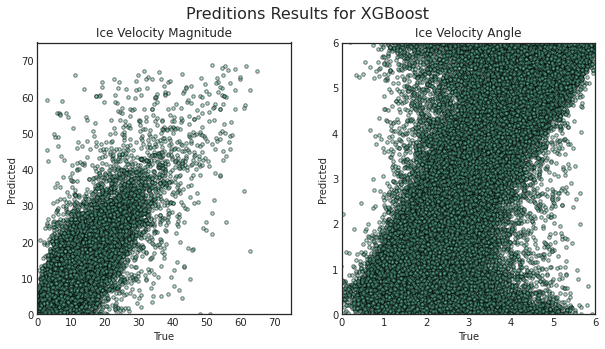

In [24]:
############
# XGBoost
############
rmse_mag = mean_squared_error(test_labels[0], XGBpredictions_mag, squared=False)
rmse_dir = mean_squared_error(test_labels[1], XGBpredictions_dir, squared=False)

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
fig.suptitle('Preditions Results for ' + 'XGBoost', fontsize=16)

ax1.scatter(XGBpredictions_mag, test_labels[0], s=12, edgecolors='k', alpha=0.5)
ax1.set_ylabel("Predicted")
ax1.set_xlabel("True")
ax1.set_xlim(0, 75)
ax1.set_ylim(0, 75)
#ax1.legend()
ax1.set_title('Ice Velocity Magnitude')

ax2.scatter(XGBpredictions_dir, test_labels[1], s=12, edgecolors='k', alpha=0.5)
ax2.set_ylabel("Predicted")
ax2.set_xlabel("True")
ax2.set_xlim(0, 6)
ax2.set_ylim(0, 6)
#ax2.legend()
ax2.set_title('Ice Velocity Angle')

print("Overall RMSE for velocity magnitude: ", rmse_mag)
print("Overall RMSE for velocity direction: ", rmse_dir)

In [10]:
############
# Neural Networks
############
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten

NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(30, kernel_initializer='normal',input_dim = train_data.shape[1], activation='tanh'))

# The Hidden Layers :
NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(486, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(128, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(30 , kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(2, kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])
NN_model.summary()

Using TensorFlow backend.







_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 30)                270       
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3968      
_________________________________________________________________
dense_3 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_4 (Dense)              (None, 486)               124902    
_________________________________________________________________
dense_5 (Dense)              (None, 256)               124672    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dense_7 (Dense)              (None, 30)                3870      
_____

In [11]:
checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

In [12]:
history = NN_model.fit(train_data, train_labels, epochs=40, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)




Train on 210738 samples, validate on 52685 samples
Epoch 1/40





210738/210738 [==============================] - 47s 222us/step - loss: 15.9839 - mean_squared_error: 15.9839 - val_loss: 15.1372 - val_mean_squared_error: 15.1372

Epoch 00001: val_loss improved from inf to 15.13718, saving model to Weights-001--15.13718.hdf5
Epoch 2/40
210738/210738 [==============================] - 40s 189us/step - loss: 14.1384 - mean_squared_error: 14.1384 - val_loss: 13.3747 - val_mean_squared_error: 13.3747

Epoch 00002: val_loss improved from 15.13718 to 13.37471, saving model to Weights-002--13.37471.hdf5
Epoch 3/40
210738/210738 [==============================] - 39s 186us/step - loss: 13.6276 - mean_squared_error: 13.6276 - val_loss: 13.0874 - val_mean_squared_error: 13.0874

Epoch 00003: val_loss improved from 13.37471 to 13.08739, saving model to Weights-003--13.08739.hdf5
Epoch 4/40
210738/210738 [==============================] - 39s 185us/step - loss: 13.2194 - mean_squared_error: 13

210738/210738 [==============================] - 102s 483us/step - loss: 10.9235 - mean_squared_error: 10.9235 - val_loss: 12.4428 - val_mean_squared_error: 12.4428

Epoch 00026: val_loss did not improve from 10.99115
Epoch 27/40
210738/210738 [==============================] - 207s 982us/step - loss: 10.8506 - mean_squared_error: 10.8506 - val_loss: 11.0956 - val_mean_squared_error: 11.0956

Epoch 00027: val_loss did not improve from 10.99115
Epoch 28/40
210738/210738 [==============================] - 167s 794us/step - loss: 10.8059 - mean_squared_error: 10.8059 - val_loss: 11.1145 - val_mean_squared_error: 11.1145

Epoch 00028: val_loss did not improve from 10.99115
Epoch 29/40
210738/210738 [==============================] - 142s 674us/step - loss: 10.7723 - mean_squared_error: 10.7723 - val_loss: 10.8671 - val_mean_squared_error: 10.8671

Epoch 00029: val_loss improved from 10.99115 to 10.86706, saving model to Weights-029--10.86706.hdf5
Epoch 30/40
210738/210738 [================

In [13]:
# Get the mean absolute error on the validation data :
#weights_path = "Weights-019--11.18656.hdf5"
#NN_model.load_weights(str.encode(weights_path))

NNpredictions = NN_model.predict(test_data)
MAE = mean_absolute_error(test_labels , NNpredictions)
print('NN validation MAE for Buoy velocity direction = ',MAE)

NN validation MAE for Buoy velocity direction =  1.9205598577230407


In [14]:
history_dict = history.history
print(history_dict)
history_dict.keys()

{'val_loss': [15.137177493683785, 13.374712346918592, 13.087392288255796, 12.49548912464673, 12.762287851206727, 12.221904472292426, 12.978752413399704, 12.180523339740644, 11.82253801719258, 11.928370589753804, 11.73720637438498, 11.952322249146897, 12.612125253835755, 11.607844129658135, 11.605406808613305, 11.859745041455424, 11.442388198510784, 11.345800695775004, 11.472150333658323, 11.592347482418985, 11.402842258345846, 11.06350616139389, 11.489900580988422, 11.179323336461966, 10.991151797600622, 12.44279303629009, 11.095551807812296, 11.1145126085733, 10.867062103005031, 11.094568184954602, 11.059360267564582, 11.35531233810797, 11.359977364990373, 11.496312901045346, 10.857870701303561, 10.76392629383931, 10.870953129043137, 11.020564159166318, 10.979415461672453, 10.920323303481869], 'val_mean_squared_error': [15.137177493683785, 13.374712346918592, 13.087392288255796, 12.49548912464673, 12.762287851206727, 12.221904472292426, 12.978752413399704, 12.180523339740644, 11.82253

dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])

# Evaluation and plotting

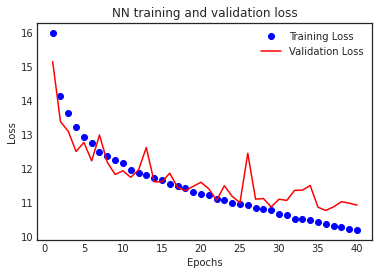

In [15]:
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values)+1) 

val_mean_squared_values = history_dict["val_mean_squared_error"]
mean_squared_values = history_dict["mean_squared_error"]

plt.plot(epochs, loss_values, 'bo', label="Training Loss")
plt.plot(epochs, val_loss_values, 'r', label="Validation Loss")
plt.title("NN training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

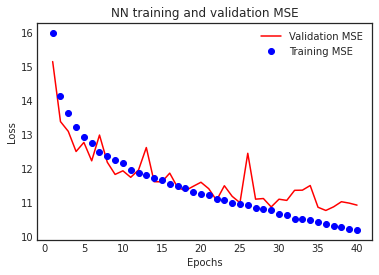

In [20]:
plt.plot(epochs, val_mean_squared_values, 'r', label="Validation MSE")
plt.plot(epochs, mean_squared_values, 'bo', label="Training MSE")
plt.title("NN training and validation MSE")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [52]:
NNpredictions = pd.DataFrame(NNpredictions, columns=["Angle",  "Magnitude"])

# Calculate the combined regression scores
print("Combined Regression Scores for NN: ")
print("Explained Variance Regression Score: ", explained_variance_score(NNpredictions, test_labels))
print("Mean Absolute Error: ", mean_absolute_error(NNpredictions, test_labels)) 
print("RMSE: ", mean_squared_error(NNpredictions, test_labels))
print("R Squared Score: ", r2_score(NNpredictions, test_labels))

Combined Regression Scores for NN: 
Explained Variance Regression Score:  0.14353643887528994
Mean Absolute Error:  1.9205598577230407
RMSE:  11.121645485551355
R Squared Score:  0.1426623735030716


Overall RMSE velocity direction:  1.2823067373210388
Overall RMSE velocity magnitude:  4.538609963691963


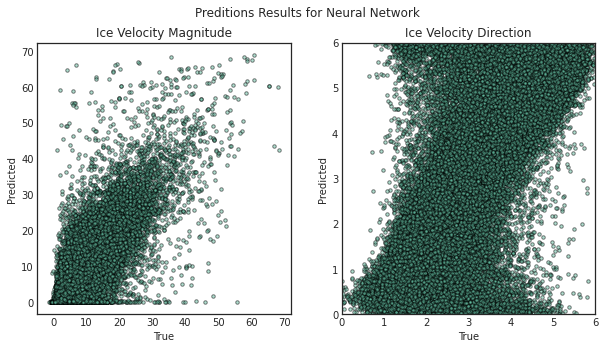

In [51]:
#################
# Neural Networks
#################

rmse_nn_dir = mean_squared_error(test_labels.iloc[:,1], NNpredictions.iloc[:,1], squared=False)
rmse_nn_mag = mean_squared_error(test_labels.iloc[:,0], NNpredictions.iloc[:,0], squared=False)
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(10, 5)
fig.suptitle('Preditions Results for ' + 'Neural Network')

ax1.scatter(NNpredictions.iloc[:,0], test_labels.iloc[:,0],s=12, edgecolors='k', alpha=0.5)
ax1.set_ylabel("Predicted")
ax1.set_xlabel("True")
ax1.set_title('Ice Velocity Magnitude')

ax2.scatter(NNpredictions.iloc[:,1], test_labels.iloc[:,1],s=12, edgecolors='k', alpha=0.5)
ax2.set_ylabel("Predicted")
ax2.set_xlabel("True")
ax2.set_title('Ice Velocity Direction')

# ax1.set_xlim([0,1])
# ax1.set_ylim([0,1])
ax2.set_xlim([0,6])
ax2.set_ylim([0,6])
print("Overall RMSE velocity direction: ", rmse_nn_dir)
print("Overall RMSE velocity magnitude: ", rmse_nn_mag)

In [ ]:
# print("Regression Score for random forest ", RF_model.score(test_data, test_labels))
# print("Regression Score for Random forest velocity direction ", RF_dir.score(test_data, test_labels[1]))
# print("Regression Score for Random forest velocity magnitude ", RF_mag.score(test_data, test_labels[0]))

In [47]:
print("Regression Score for XGB velocity direction ", XGBModel_dir.score(test_data, test_labels[1]))
print("Regression Score for XGB velocity magnitude ", XGBModel_mag.score(test_data, test_labels[0]))

Regression Score for XGB velocity direction  0.5138881400539603
Regression Score for XGB velocity magnitude  0.6883537425359264


# save models

In [ ]:
import pickle
pickle.dump(XGBModel_mag, open('models/XGBModel_mag_20210309.sav', 'wb'))
pickle.dump(XGBModel_dir, open('models/XGBModel_dir_20210309.sav', 'wb'))

# Run the model on test data

In [ ]:
# Load the raw data to disk
input_path = "data/converted_test.csv"
df = pd.read_csv(input_path)

# Convert all column names to lower case and display the dataframe 
df = df.rename(str.lower, axis='columns')
print(df.shape)

from sklearn import preprocessing
test = df[['ice_thickness', 'wind_vel_mag', 'wind_vel_dir', 'sic_cdr', 'buoy_lat', 'buoy_lon', 'year', 'doy']]

x = test.values #returns a numpy array
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
test = pd.DataFrame(x_scaled)
display(test)

In [ ]:
# pred_XGB_mag = XGBModel_mag.predict(test)
# pred_XGB_dir = XGBModel_dir.predict(test)
# pred_NN = NN_model.predict(test)
# pred_RF = RF_model.predict(test)

In [ ]:
# convert magnitude and direction to components
# import math
# u = []
# v = []
# for i in range(len(pred_NN)):
#     u.append(math.cos(pred_NN[i][1]) * pred_NN[i][0]) 
#     v.append(math.sin(pred_NN[i][1]) * pred_NN[i][0])

# for i in range(len(pred_NN)):
#     u.append(math.cos(pred_XGB_dir[i]) * pred_XGB_mag[i]) 
#     v.append(math.sin(pred_XGB_dir[i]) * pred_XGB_mag[i])

In [ ]:
# df_pred = pd.DataFrame()
# df_pred['buoy_vel_mag'] = pred_XGB_mag
# df_pred['buoy_vel_dir'] = pred_XGB_dir
# display(df_pred)

In [ ]:
# df_pred = pd.DataFrame()
# df_pred['buoy_vel_mag'] = pred_NN[:,0]
# df_pred['buoy_vel_dir'] = pred_NN[:,1]
# display(df_pred)

In [ ]:
#df_pred = pd.DataFrame()
#df_pred['buoy_vel_mag'] = pred_RF[:,0]
#df_pred['buoy_vel_dir'] = pred_RF[:,1]
#display(df_pred)

In [ ]:
# df_pred = pd.DataFrame()
# print(df_pred.shape)
# df_pred['u_buoy'] = u
# df_pred['v_buoy'] = v

In [ ]:
# df_pred.to_csv("predictions_nn.csv")
#df_pred.to_csv("predictions_xgb_20210309.csv")
# df_pred.to_csv("predictions_rf.csv")